In [28]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

np.random.seed(2020)
random.seed(2020)

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [29]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [31]:
class TreeRegressor(object):
    """A decision tree regressor.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self):
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """         
        return not bool(self.left_child and self.right_child)
    
    def split_dataset(self, X, y, column, value):
        """ Split dataset by a particular column and value
        Args:
            X: 2-dimensional numpy-array (N, num_feats). N-number of samples
            y: 1-dimensional numpy-array of targets with shape (N,)  
            column (int): the column by which the X should be splitted
            value (float): the value by which the column should be splitted
        Returns:
            Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
            left_X, right_X, left_y, right_y
        """       
        left_mask = X[:, column] < value
        right_mask = X[:, column] >= value
        left_y, right_y = y[left_mask], y[right_mask]
        left_X, right_X = X[left_mask], X[right_mask]
        return left_X, right_X, left_y, right_y
    
    def _ssr(self, X, y, tresholds):
        residuals = np.zeros(len(tresholds))
        for i in range(0, len(tresholds)):
            x_l_mask = X < tresholds[i]
            x_r_mask = X > tresholds[i]
            y_l = y[x_l_mask]
            y_r = y[x_r_mask]
            av_l = np.mean(y_l)
            av_r = np.mean(y_r)
            residuals[i] = np.sum(np.power(y_l-av_l, 2)) + np.sum(np.power(y_r-av_r, 2))
        return residuals

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = np.zeros(X.shape[0]-1)

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values[i-1] = average
        return list(split_values)
    
    def _find_best_split(self, X, y):
        y_ = y
        min_ssr_feature = np.zeros(X.shape[1])
        treshold_feature = np.zeros(X.shape[1])
    
        for i in range(0,X.shape[1]):
            x_ = X[:,i]
            tresholds_ = self._find_splits(x_)
            ssr_ = self._ssr(x_, y_, tresholds_)
            min_ssr_feature[i] = np.min(ssr_)
            treshold_feature[i] = tresholds_[np.argmin(ssr_)]
            
        min_ssr = np.min(min_ssr_feature)
        feature = np.argmin(min_ssr_feature)
        treshold = treshold_feature[feature]
        return feature, treshold, min_ssr
    

    def fit(self, X, y, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                label = 'max_depth'
                assert max_depth > 0
                max_depth -= 1
            
            label = 'sample counts'
            assert y.shape[0] > 1
            
            column, value, ssr = self._find_best_split(X, y)

            self.column_index = column
            self.threshold = value

            # Split dataset
            left_X, right_X, left_target, right_target = self.split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = TreeRegressor()
            self.left_child.fit(
                left_X, left_target, max_depth
            )

            self.right_child = TreeRegressor()
            self.right_child.fit(
                right_X, right_target, max_depth
            )
            
        except AssertionError:
            self.outcome_probs = np.mean(y)
            

    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

_ssr() function computes sum of squared residuals from average of left and right samples for each possible tresholds for feature. Feature and treshold corresponding to min of _ssr() are selected as the best splitting. In fit()another assert is added which stop splitting when count of samples is 1. Value in leaf nodes is average of splitted sample.

Let's compare performing of custom DecisionTreeRegressor and library function.

In [32]:
model = TreeRegressor()
model.fit(X_train, y_train, max_depth=3)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {r2_score(y_test, y_pred)}")

Accuracy score is: 0.770468769232217


In [33]:
dec_tree = DecisionTreeRegressor(max_depth=3)
dec_tree.fit(X_train, y_train)
y_hat = dec_tree.predict(X_test)
print(f"Accuracy score is: {r2_score(y_test, y_hat)}")

Accuracy score is: 0.770468769232217


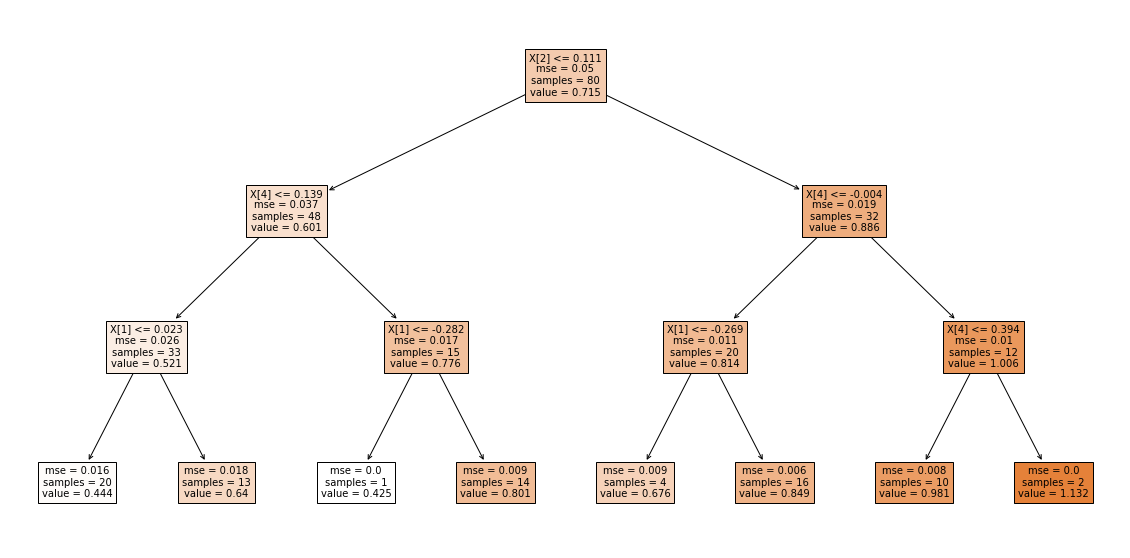

In [34]:
plt.figure(figsize=(20,10))
tree.plot_tree(dec_tree, fontsize=10, filled=True)
plt.show()

In [35]:
print(set(y_pred))
print(set(y_hat))

{0.44384389711707745, 0.8490654741959979, 0.6399100429332153, 0.980533214065845, 0.8006393680729138, 0.4245300273243632}
{0.4438438971170774, 0.8490654741959979, 0.6399100429332152, 0.980533214065845, 0.8006393680729139, 0.4245300273243632}


As we can they have the same outputs

**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [36]:
class ForestRegressor(object):
    """
    A random forest regressor.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.trees = [TreeRegressor() for _ in range(n_estimators)]
        
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        # создает рандомной массив целых чисел до size
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = X.shape[1]
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions
        else:
            raise ValueError("You should fit a model before `predict`")

In [37]:
rf = ForestRegressor(n_estimators=10, max_depth=3)
rf.fit(X_train, y_train)

C:\Users\apple\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\apple\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
y_pred = rf.predict(X_test)
print(f"Accuracy score is: {r2_score(y_test, y_hat)}")

Accuracy score is: 0.8451737275766474


In [41]:
from sklearn.ensemble import RandomForestRegressor

rfr_clf = RandomForestRegressor(n_estimators=10, max_depth=3)
rfr_clf.fit(X_train, y_train)
y_hat = rfr_clf.predict(X_test)
print(f"Accuracy score is: {r2_score(y_test, y_hat)}")

Accuracy score is: 0.8451737275766474


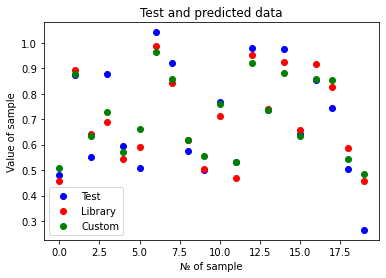

In [48]:
plt.scatter(range(0, y_test.shape[0]), y_test, c='blue', label='Test')
plt.scatter(range(0, y_test.shape[0]), y_hat, c='red', label='Library')
plt.scatter(range(0, y_test.shape[0]), y_pred, c='green', label='Custom')
plt.title('Test and predicted data')
plt.xlabel('№ of sample')
plt.ylabel('Value of sample')
plt.legend()
plt.show()